In [1]:
PYDEVD_DISABLE_FILE_VALIDATION=1

In [15]:
pip install opencv-python

In [16]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import cv2

import glob
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import torch
from torchvision import transforms
import os
import cv2
import glob
import re
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

provNum, alphaNum, adNum = 38, 25, 35
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

def multi_glob(pattern_base):
    return glob.glob(os.path.join(pattern_base, "*"))

def collect_image_paths(base_folder, ext="*.jpg"):
    image_paths = []
    for folder in glob.glob(os.path.join(base_folder, "*/")):
        image_paths.extend(glob.glob(os.path.join(folder, ext)))

        # for tasting
        image_paths = image_paths[:len(image_paths)//3]
        # -----------

    return image_paths

def get_imgs_resolutions(path):
    s = set()
    for i in collect_image_paths(path):
        s.add(Image.open(i).size)
    return s

def create_dataloader(trainds, testds):

    trainloader = torch.utils.data.DataLoader(trainds, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader(testds, batch_size=128, shuffle=False)

    return trainloader, testloader

# class GenerateDataset(Dataset):
#     def __init__(self, paths, labels=None, transform=None, split_data=False, test_size=0.2, random_state=42):
#         if split_data:
#             if labels is not None:
#                 self.train_paths, self.test_paths, self.train_labels, self.test_labels = train_test_split(
#                     paths, labels, test_size=test_size, random_state=random_state
#                 )
#             else:
#                 self.train_paths, self.test_paths = train_test_split(
#                     paths, test_size=test_size, random_state=random_state
#                 )
#                 self.train_labels, self.test_labels = None, None
#         else:
#             self.paths = paths
#             self.labels = labels

#         self.split_data = split_data

#         if transform is None:
#             self.transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
#             ])
#         else:
#             self.transform = transform

#     def get_train_dataset(self):
#         if not self.split_data:
#             raise ValueError("ERROR_01")
#         return GenerateDataset(self.train_paths, self.train_labels, self.transform, split_data=False)

#     def get_test_dataset(self):
#         if not self.split_data:
#             raise ValueError("ERROR_02")
#         return GenerateDataset(self.test_paths, self.test_labels, self.transform, split_data=False)

#     def __len__(self):
#         return len(self.paths)

#     def __getitem__(self, idx):
#         img = Image.open(self.paths[idx]).convert("RGB")
#         if self.transform:
#             img = self.transform(img)
#         if self.labels is not None:
#             return img, self.labels[idx]
#         return img


class GenerateDataset(Dataset):
    def __init__(self, paths, transform=None, split_data=False, test_size=0.2, random_state=42):
        if split_data:
            self.train_paths, self.test_paths = train_test_split(
                paths, test_size=test_size, random_state=random_state
            )
        else:
            self.paths = paths

        self.split_data = split_data


        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((180, 290)), #скейл /4
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

    def get_train_dataset(self):
        if not self.split_data:
            raise ValueError("ERROR_01")
        return GenerateDataset(self.train_paths, self.transform, split_data=False)

    def get_test_dataset(self):
        if not self.split_data:
            raise ValueError("ERROR_02")
        return GenerateDataset(self.test_paths, self.transform, split_data=False)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        new_w, new_h = 290, 180
        img = Image.open(img_path).convert("RGB")

        w, h = img.size

        if self.transform:
            img = self.transform(img)

        # отримуємо бокси для зображення (припустимо, є така функція)
        target = get_box_coordinates(parse_coordinates(get_coordinates(img_path)))
        x1, y1, x2, y2 = target
        target = torch.tensor([x1/new_w, y1/new_h, x2/new_w, y2/new_h], dtype=torch.float)

        return img, target


def transform_sample(pth):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(pth).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

# boxes operations and creations
def get_coordinates(coord_string):
    info = str(coord_string.split("\\")).split("-")
    return info[3]

def get_plate_number(coord_string):
    info = str(coord_string.split("\\")).split("-")
    plate = ''
    number = info[4].split("_")
    plate += provinces[int(number[0])]
    for ind in range(1, len(number)):
        plate += ads[int(number[ind])]
    return plate

def parse_coordinates(coord_string):
    numbers = re.findall(r'\d+', coord_string)
    coords = [int(x) for x in numbers]

    boxes = []
    for i in range(0, len(coords), 4):
        if i + 3 < len(coords):
            x1, y1, x2, y2 = coords[i:i+4]
            boxes.append({
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'width': abs(x2 - x1),
                'height': abs(y2 - y1)
            })

    return boxes

def normalize_box(box):
    x_min = min(box['x1'], box['x2'])
    y_min = min(box['y1'], box['y2'])
    x_max = max(box['x1'], box['x2'])
    y_max = max(box['y1'], box['y2'])
    return x_min, y_min, x_max, y_max

def get_box_coordinates(boxes):
    if len(boxes) >= 1:
        if len(boxes) == 2:
            # нормалізуємо обидва бокси
            norm_boxes = [normalize_box(b) for b in boxes]

            x1 = min(b[0] for b in norm_boxes)
            y1 = min(b[1] for b in norm_boxes)
            x2 = max(b[2] for b in norm_boxes)
            y2 = max(b[3] for b in norm_boxes)

            return x1, y1, x2, y2
        else:
            for box in boxes:
                x1, y1 = box['x1'], box['y1']
                x2, y2 = box['x2'], box['y2']
            return x1, y1, x2, y2



def draw_boxes(image_path, boxes):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1, y1, x2, y2 = get_box_coordinates(boxes)

    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis("off")
    plt.show()

boxes = [
    {'x1': 405, 'y1': 571, 'x2': 235, 'y2': 574, 'width': 170, 'height': 3},
    {'x1': 231, 'y1': 523, 'x2': 403, 'y2': 522, 'width': 172, 'height': 1}
]



def predict_and_draw(model, image_path, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((180, 290)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    w_orig, h_orig = img.size
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.no_grad():
        pred = model(input_tensor)

    pred = pred.squeeze(0).cpu()

    x1 = int(pred[0].item() * w_orig)
    y1 = int(pred[1].item() * h_orig)
    x2 = int(pred[2].item() * w_orig)
    y2 = int(pred[3].item() * h_orig)

    img_cv = cv2.imread(image_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img_cv)
    plt.axis("off")
    plt.show()

    return pred

In [99]:
ls drive/MyDrive/data/VLPR/ds/data_splited

test/  train/  val/


In [112]:
full_dataset = GenerateDataset(collect_image_paths(r'drive/MyDrive/data/VLPR/ds/data_splited'), split_data=True, test_size=0.2)

train_dataset = full_dataset.get_train_dataset()
test_dataset = full_dataset.get_test_dataset()

trainloader, testloader = create_dataloader(train_dataset, test_dataset)

In [113]:
len(train_dataset)

1594

In [114]:
class BoxRegressorCNN(nn.Module):
    def __init__(self):
        super(BoxRegressorCNN, self).__init__()
        self.features_ext = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), #90 145
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #45 73
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #23 37
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), #12 19
            nn.ReLU(),
            )

        self.adapt = nn.AdaptiveAvgPool2d((4,4))

        self.linear = nn.Sequential(
            # nn.Linear(256*4*19, 1024),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),

            )

        self.result = nn.Linear(512, 4)


    def forward(self, x):
        x = self.features_ext(x)
        x = self.adapt(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)# flatten all dimensions except batch
        out = torch.sigmoid(self.result(x))
        return out

model = BoxRegressorCNN()
# device = xm.xla_device() # TPU
# model.to(device)

In [115]:
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [116]:
# TPU
# import torch_xla
# import torch_xla.core.xla_model as xm


def train_model(model, trainloader, testloader, epochs=10, device=None):
    try:
        device = xm.xla_device()  # TPU замість CUDA
        model.to(device)
    except:
        device = 'cpu'

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for imgs, targets in trainloader:
            imgs, targets = imgs.to(device), targets.to(device)

            preds = model(imgs)            # [B, 4]
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            # xm.optimizer_step(optimizer)   # TPU
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)

        # середній train loss
        train_loss /= len(trainloader.dataset)

        # валідація
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in testloader:
                imgs, targets = imgs.to(device), targets.to(device)
                preds = model(imgs)
                loss = criterion(preds, targets)
                val_loss += loss.item() * imgs.size(0)

        val_loss /= len(testloader.dataset)

        # xm.master_print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}") # TPU
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}") # CPU


    return model

In [117]:
device = 'cpu'
imgs, targets = next(iter(testloader))

imgs, targets = imgs.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    preds = model(imgs)

print(preds.shape)

torch.Size([128, 4])


In [118]:
train_model(model, trainloader, testloader, epochs=10)

Epoch 1/10 | Train Loss: 1.0924 | Val Loss: 0.8938
Epoch 2/10 | Train Loss: 0.8049 | Val Loss: 0.7837
Epoch 3/10 | Train Loss: 0.7840 | Val Loss: 0.7814
Epoch 4/10 | Train Loss: 0.7829 | Val Loss: 0.7810
Epoch 5/10 | Train Loss: 0.7831 | Val Loss: 0.7807
Epoch 6/10 | Train Loss: 0.7829 | Val Loss: 0.7807
Epoch 7/10 | Train Loss: 0.7826 | Val Loss: 0.7805
Epoch 8/10 | Train Loss: 0.7823 | Val Loss: 0.7801
Epoch 9/10 | Train Loss: 0.7821 | Val Loss: 0.7800
Epoch 10/10 | Train Loss: 0.7821 | Val Loss: 0.7800


BoxRegressorCNN(
  (features_ext): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (adapt): AdaptiveAvgPool2d(output_size=(4, 4))
  (linear): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
  )
  (result): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
test_path = r'Volkswagen-Tiguan-2024-1280-0b-3885198800.jpg'

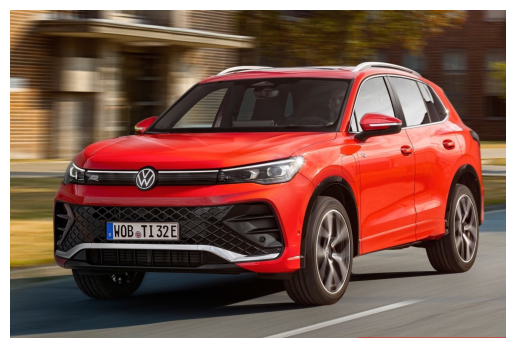

In [120]:
pred = predict_and_draw(model, test_path)

In [121]:
pred

tensor([0.7024, 1.0000, 1.0000, 1.0000])